# Лабораторная работа



## Теория

Облако точек - это самый простой способ представления различных объектов в виде неупорядоченного набора точек в трехмерной плоскости. Такие данные можно получить с помощью сканирования предметов или их структуры с помощью 3D-датчиков, например LiDAR. Качественные облака точек с высокой точностью измерения позволяют представить цифровую версию реального мира.

<figure>
<center>
<img src='https://www.codeproject.com/KB/openGL/839389/bunny_points.PNG' />
<figcaption>Стэндфордский кролик</figcaption></center>
</figure>

Как правило, при глубоком обучении трехмерного облака точек необходимо решить две задачи: классификацию и сегментацию.
Основная проблема работы с облаком точек заключается в том, что типичная сверточная архитектура требует упорядоченный формат входных данных (например, изображение). Поскольку облако точек не является таким, общепринятые подходы заключаются в преобразовании данных в обычную 3D-воксельную сетку или проекцию.

В данной лабораторной работе используется эффективный подход для сегментации - DBSCAN.

DBSCAN (кластеризация на основе плотности) - плотностной алгоритм пространственной кластеризации с присутствием шума. Он определяет кластер произвольной формы в пространстве как максимальный набор точек, связанных достаточно высокой плотностью. Каждый объект, не содержащийся ни в одном кластере, автоматически считается шумом. Этот метод чувствителен к таким параметрам, как эпсилон (eps) и количество образцов в окрестностях для точки, которую следует рассматривать как основную точку (min_pts).

<figure>
<center>
<img src='https://www.researchgate.net/publication/342871651/figure/fig3/AS:912165510840320@1594488613526/The-graphical-representation-of-the-key-components-of-the-DBSCAN-algorithm-a-a.png' />
<figcaption>Работа алгоритма DBSCAN: (a) кластер, (b) основная точка (синяя точка), (c) пограничная точка (желтая точка), (d) точки, доступные для области</figcaption></center>
</figure>

DBSCAN выполняет итерацию по случайным точкам в наборе данных. Для каждой рассматриваемой точки он вычисляет окрестности этой точки, и если эта окрестность содержит более определенного количества точек, она включается в область. Каждая соседняя точка проходит через один и тот же процесс до тех пор, пока она больше не сможет расширять кластер. Если рассматриваемая точка не является внутренней точкой, т.е. у нее недостаточно соседей, она будет помечена как шум. Это позволяет DBSCAN быть устойчивым к выбросам.

## Импорт библиотек

In [28]:
!pip install open3d
!pip install h5py
!pip install pandas
!pip install pyntcloud
!pip install pptk
!pip install kneed


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import glob
import h5py
import numpy as np
import open3d as o3d
from sklearn.cluster import DBSCAN, OPTICS, SpectralClustering, AgglomerativeClustering
from sklearn import metrics
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import product
import pandas as pd
from pyntcloud import PyntCloud
import pptk
import random
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Метки (labels) варьируются от -1 до n, где -1 указывает, что это точка с "шумом", а значения от 0 до n - это метки кластера, присвоенные соответствующей точке. Для удобства каждой точке определенной метки присваивается свой цвет.

max_label сохраняет максимальное значение в списке меток. Для зашумленных точек со значением метки "-1" позже присваивается значение черного цвета (black).

In [2]:
# функция для сегментации
def segment_pcd(X, pcd, points, user_eps, user_min_samp):
  clustering = DBSCAN(eps=user_eps, min_samples=user_min_samp, algorithm='ball_tree').fit(X)
  labels=clustering.labels_
  
  max_label = labels.max() + 1

  obj_points=[]
  for i in range(max_label):
    idx_labels = np.where(labels==i)
    obj_points.append(points[idx_labels])

  idx_layer=np.where(labels<0)
  colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
  colors[labels < 0] = 0
  pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

  return pcd, colors, max_label, obj_points

In [3]:
# функция для графического отображения облака точек
def draw_plot(points, colors=None):
  fig = go.Figure(
      data=[
          go.Scatter3d(
              x=points[:,0], y=points[:,1], z=points[:,2], 
              mode='markers',
              marker=dict(size=1, color=colors)
          )
      ],
      layout=dict(
          scene=dict(
              xaxis=dict(visible=False),
              yaxis=dict(visible=False),
              zaxis=dict(visible=False)
          )
      )
      )
  return fig

In [4]:
# функция для графического отображения облака точек2
def draw_plot2(points, colors=None):
#   fig = go.Figure(
#       data=[
#           go.Scatter3d(
#               x=points[:,0], y=points[:,1], z=points[:,2], 
#               mode='markers',
#               marker=dict(size=1, color=colors)
#           )
#       ],
#       layout=dict(
#           scene=dict(
#               xaxis=dict(visible=False),
#               yaxis=dict(visible=False),
#               zaxis=dict(visible=False)
#           )
#       )
#       )
    pptk.viewer(points, colors)
#   return fig

In [5]:
# функция присваивания цвета точке
def add_color(pcd, colors):
  if pcd.has_colors():
    colors = np.asarray(pcd.colors)
  elif pcd.has_normals():
    colors = (0.0, 0.5, 0.5) + np.asarray(pcd.normals) * 0.5
  else:
    pcd.paint_uniform_color((0.0, 0.0, 0.0))
    colors = np.asarray(pcd.colors)
  return pcd, colors

In [6]:
# функция для представления набора точек в pcd
def np_to_pcd(points):
  colors = np.zeros(points.shape)
  for i in range(0,points.shape[0]):
    colors[i][0] = 0.12156863
    colors[i][1] = 0.46666667
    colors[i][2] = 0.70588235
  point_cloud = o3d.geometry.PointCloud()
  point_cloud.points = o3d.utility.Vector3dVector(points)
  point_cloud.colors = o3d.utility.Vector3dVector(colors)
  return point_cloud

In [7]:
# функция получения массива координат
def get_points(file_path):
    my_file = PyntCloud.from_file(file_path)
    my_df = pd.DataFrame(data=my_file.points, columns=['x', 'y', 'z'])
    my_points = np.asarray(my_df)
    return my_points

In [8]:
# снижение размерности облака точек до ~num_points
def down_pcd(data, num_points):
    if data.shape[0] > num_points:
        factor = data.shape[0] // num_points
    else:
        factor = 1
    down_data = data[::factor]
    return down_data

# down_data = down_pcd(data, 40000)

In [9]:
# снижение размерности облака точек с учетом высоты расположения точек
def down_pcd2(data, num_points):
    if data.shape[0] > num_points:
        factor = data.shape[0] // num_points
    else:
        factor = 1
    down_data = data[::factor]
    
    z_list = [d[2] for d in down_data]
    z_max = max(z_list)
    
    res_data = []
    for point in down_data:
        if z_max - point[2] < random.random() * 30:
            res_data.append(point)
    print(f'amount of points: {len(res_data)}')
    
    return np.asarray(res_data, dtype = np.float32)

# down_data = down_pcd(data, 40000)

## Загрузка набора данных

In [10]:
DATA_DIR = "C:\PycharmProjects\OAD_NIRS"

In [11]:
# my_seg_points = get_points("C:\PycharmProjects\OAD_NIRS\CPL1_1_clone_segmented.pcd")
my_seg_points = get_points("C:\PycharmProjects\OAD_NIRS\CPL1_1.pcd")
my_seg_points

array([[-42.6213,   6.3661,  10.4073],
       [-43.5713,   6.9652,  12.8294],
       [-42.5652,   6.5576,   8.2075],
       ...,
       [-42.6098,   6.6626,  13.0716],
       [-42.5959,   6.5193,  13.0087],
       [-42.6808,   6.3992,  14.8912]], dtype=float32)

In [12]:
my_seg_points.shape[0]

39569319

In [13]:
my_seg_points[0]

array([-42.6213,   6.3661,  10.4073], dtype=float32)

In [13]:
my_lower = []
my_higher = []

In [14]:
%%time
for point in my_seg_points:
    if point[2]>=8:
        my_higher.append(point)
    else:
        my_lower.append(point)
my_higher

Wall time: 2min 42s


[array([-42.6213,   6.3661,  10.4073], dtype=float32),
 array([-43.5713,   6.9652,  12.8294], dtype=float32),
 array([-42.5652,   6.5576,   8.2075], dtype=float32),
 array([-42.6242,   6.4554,  13.4372], dtype=float32),
 array([-42.6308,   6.5921,  13.5129], dtype=float32),
 array([-43.5482,   7.9238,  12.5972], dtype=float32),
 array([-40.7736,   6.5214,  20.4046], dtype=float32),
 array([-40.7008,   6.6476,  20.4516], dtype=float32),
 array([-43.2453,   8.9599,  12.8115], dtype=float32),
 array([-62.599 ,  10.0029,  19.6222], dtype=float32),
 array([-42.5726,   6.5488,  13.2443], dtype=float32),
 array([-41.171 ,   8.8142,  24.3672], dtype=float32),
 array([-48.7484,   7.7502,  14.7492], dtype=float32),
 array([-42.5663,   6.6405,  12.8426], dtype=float32),
 array([-42.6042,   6.5052,  12.7987], dtype=float32),
 array([-42.5837,   6.4483,   8.5151], dtype=float32),
 array([-43.4325,   7.9188,  11.2019], dtype=float32),
 array([-42.6389,   6.508 ,  15.7799], dtype=float32),
 array([-4

In [15]:
my_higher2 = np.asarray(my_higher)
my_higher2

array([[-42.6213,   6.3661,  10.4073],
       [-43.5713,   6.9652,  12.8294],
       [-42.5652,   6.5576,   8.2075],
       ...,
       [-42.6098,   6.6626,  13.0716],
       [-42.5959,   6.5193,  13.0087],
       [-42.6808,   6.3992,  14.8912]], dtype=float32)

In [16]:
%%time
my_lower2 = np.asarray(my_lower)
my_lower2

Wall time: 6min 22s
Parser   : 188 ms


array([[-59.5196,  13.2405,   2.1016],
       [-58.6804,  12.5412,   4.1378],
       [-42.5003,   6.623 ,   2.5317],
       ...,
       [-59.5045,  13.1819,   3.5887],
       [-59.609 ,  13.0355,   3.7161],
       [-42.5569,   6.4187,   6.8394]], dtype=float32)

In [17]:
my_higher2.shape[0]

7595383

In [18]:
my_lower2.shape[0]

31973936

In [19]:
points_h=down_pcd(my_higher2, 50000)
points_h.shape[0]

50301

In [20]:
points_l=down_pcd(my_lower2, 150000)
points_l.shape[0]

150113

In [24]:
points = down_pcd(my_seg_points, 200000)

In [14]:
points = down_pcd2(my_seg_points, 1600000)

amount of points: 212173


In [88]:
# points = my_seg_points[0:100000]
# # points = my_seg_points
# points

In [21]:
# points = down_pcd(my_seg_points, 200000)
# for point in points_l:
#     points.append(point)
# for point in points_h:
#     points.append(point)
points = np.vstack((points_l, points_h))
points

array([[-59.5196,  13.2405,   2.1016],
       [-53.8538,  11.0422,   0.9335],
       [-60.7705,  38.0421,   1.6089],
       ...,
       [-41.4683,  12.0802,  19.2266],
       [-49.2611,   8.264 ,  20.9857],
       [-48.7192,   7.7546,  23.497 ]], dtype=float32)

In [83]:
# points

In [23]:
points.shape[0]

1

In [12]:
colors = None
draw_plot2(my_seg_points, colors)

ValueError: 0-th attribute array shape is not supported

In [15]:
colors = None
draw_plot2(points, colors)

ValueError: 0-th attribute array shape is not supported

In [16]:
# h5f = h5py.File(os.path.join(DATA_DIR, "segmentation-dataset.h5"),'r')
# df = h5f.get('dataset_a')[:]
# h5f.close()

In [17]:
# датасет содержит 12 облаков точек, которые состоят из 10000 точек
# df.shape

In [18]:
# points = np.asarray(df[7])
pcd = np_to_pcd(points)
colors = None

In [98]:
# points

In [19]:
pcd, colors = add_color(pcd, colors)
X = np.asarray(pcd.points)

In [99]:
# draw_plot2(points, colors)

1.7122821171022493


<Figure size 2000x1000 with 0 Axes>

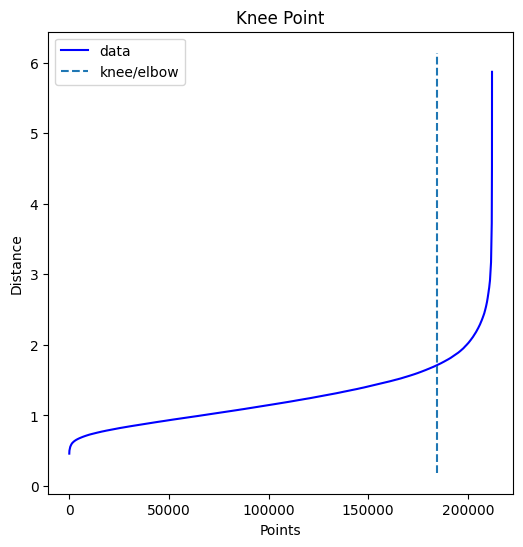

In [65]:
n_neighbors=80
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors+1)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,n_neighbors], axis=0)

i=np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(20, 10))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])
#grad

In [90]:
# настройка основных параметров модели
# eps - размер окрестности точки
# min_pts - минимальное кол-во точек в окрестности

# макс. база
# eps = 0.5
# min_pts = 276

# 0.26 70 > 0.26 66
# 0.26 70 > 0.26 74

# 0.3 78

# 0.34 154 > 0.34 166

# 0.38 154

# 0.46 162

# 0.54 170 пока лучший

# 0.58 190?

# 0.7 274?

# Проредил с границей различия прореживания 8 м, 50k/150k, пояс, но выглядит приятно-кластеризованным 0.75 75; 0.8 хуже

# 0.45 5 охватило много точек, однако деревья не отдельные, а группами; 0.45 15 меньше группы, но много шума

# 0.6 10/13/14?

# 0.60-65 10? 62/63? 64 20 без верх? 0.7 23 низушки не очень?

# 8 м, 40k/160k, пояс есть

# 8 м, 30k/170k, пояс хуже видно, результаты не сильно лучше, верх постепенно умирает

# 0.64 20 без верх

# Попробуем 15 м. Граница выше хуже.

# 5 м

# 12 м 50k/150k? Видимо все-таки 8 м

# Попробуем градиентно на параметр 1600000, 0.6 20 - не, 0.5 10? 0.6 15?
#grad
eps = 1.712
min_pts = 220

In [91]:
%%time
pcd, colors = add_color(pcd, colors)
X = np.asarray(pcd.points)
max_label, obj_points = None, None
# new_pcd, colors, max_label, obj_points, labels = segment_pcd(X, pcd, points, eps, min_pts)
new_pcd, colors, max_label, obj_points = segment_pcd(X, pcd, points, eps, min_pts)
print(f"Распознано {max_label} объектов в облаке точек")
# print(metrics.silhouette_score(X, labels))

Распознано 32 объектов в облаке точек
Wall time: 5.04 s


In [92]:
points = np.asarray(pcd.points)
new_pcd, colors = add_color(new_pcd, colors)

draw_plot2(points, colors)

In [43]:
%%time
# eps_search_values = np.arange(0.02, 1, 0.02)
eps_search_values = [0.5]
min_pts_search_values = np.arange(2, 600, 2)
# min_pts_search_values = [120]
segm_pars = list(product(eps_search_values, min_pts_search_values))
# segm_pars
checked_eps = []
checked_min_pts = []
clusters_cnt = []
# noisy_cnt = []
for i in segm_pars:
    search_clustering = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps.append(i[0])
    checked_min_pts.append(i[1])
    clusters_cnt.append(len(np.unique(search_clustering.labels_)))
#     noisy_cnt.append(list(labels).count(-1))
zipped_data = list(zip(checked_eps, checked_min_pts, clusters_cnt))
check_df = pd.DataFrame(zipped_data, columns=['eps', 'min_pts', 'clusters_cnt'])
check_df

Wall time: 5min 38s


eps  min_pts  clusters_cnt
0    0.5        2           350
1    0.5        4           203
2    0.5        6           162
3    0.5        8           125
4    0.5       10           108
..   ...      ...           ...
294  0.5      590             5
295  0.5      592             5
296  0.5      594             5
297  0.5      596             5
298  0.5      598             5

[299 rows x 3 columns]

In [60]:
%%time
eps_search_values2 = np.arange(0.02, 1, 0.02)
# eps_search_values = [0.5]
# min_pts_search_values = np.arange(2, 600, 2)
min_pts_search_values2 = [120]
segm_pars2 = list(product(eps_search_values2, min_pts_search_values2))
# segm_pars
checked_eps2 = []
checked_min_pts2 = []
clusters_cnt2 = []
for i in segm_pars2:
    search_clustering2 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps2.append(i[0])
    checked_min_pts2.append(i[1])
    clusters_cnt2.append(len(np.unique(search_clustering2.labels_)))
zipped_data2 = list(zip(checked_eps2, checked_min_pts2, clusters_cnt2))
check_df2 = pd.DataFrame(zipped_data2, columns=['eps', 'min_pts', 'clusters_cnt'])
check_df2

Wall time: 59.2 s


eps  min_pts  clusters_cnt
0   0.02      120             1
1   0.04      120             1
2   0.06      120             1
3   0.08      120             1
4   0.10      120             1
5   0.12      120             1
6   0.14      120             1
7   0.16      120             1
8   0.18      120             3
9   0.20      120             3
10  0.22      120            11
11  0.24      120            16
12  0.26      120            20
13  0.28      120            27
14  0.30      120            28
15  0.32      120            36
16  0.34      120            34
17  0.36      120            36
18  0.38      120            40
19  0.40      120            42
20  0.42      120            44
21  0.44      120            43
22  0.46      120            56
23  0.48      120            53
24  0.50      120            50
25  0.52      120            48
26  0.54      120            45
27  0.56      120            42
28  0.58      120            46
29  0.60      120            37
30  0.62      120            35
31  0.64      120            32
32  0.66      120            25
33  0.68      120            20
34  0.70      120            17
35  0.72      120            19
36  0.74      120            16
37  0.76      120            15
38  0.78      120            13
39  0.80      120            15
40  0.82      120            10
41  0.84      120             9
42  0.86      120            10
43  0.88      120             5
44  0.90      120             7
45  0.92      120             8
46  0.94      120             8
47  0.96      120             9
48  0.98      120             9

In [27]:
%%time
eps_search_values3 = np.arange(0.02, 0.8, 0.04)
# eps_search_values = [0.5]
min_pts_search_values3 = np.arange(2, 300, 4)
# min_pts_search_values3 = [120]
segm_pars3 = list(product(eps_search_values3, min_pts_search_values3))
# segm_pars
checked_eps3 = []
checked_min_pts3 = []
clusters_cnt3 = []
for i in segm_pars3:
    search_clustering3 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps3.append(i[0])
    checked_min_pts3.append(i[1])
    clusters_cnt3.append(len(np.unique(search_clustering3.labels_)))
zipped_data3 = list(zip(checked_eps3, checked_min_pts3, clusters_cnt3))
check_df3 = pd.DataFrame(zipped_data3, columns=['eps', 'min_pts', 'clusters_cnt'])
check_df3

Wall time: 24min 9s


eps  min_pts  clusters_cnt
0     0.02        2          4341
1     0.02        6            12
2     0.02       10             1
3     0.02       14             1
4     0.02       18             1
5     0.02       22             1
6     0.02       26             1
7     0.02       30             1
8     0.02       34             1
9     0.02       38             1
10    0.02       42             1
11    0.02       46             1
12    0.02       50             1
13    0.02       54             1
14    0.02       58             1
15    0.02       62             1
16    0.02       66             1
17    0.02       70             1
18    0.02       74             1
19    0.02       78             1
20    0.02       82             1
21    0.02       86             1
22    0.02       90             1
23    0.02       94             1
24    0.02       98             1
25    0.02      102             1
26    0.02      106             1
27    0.02      110             1
28    0.02      114             1
29    0.02      118             1
30    0.02      122             1
31    0.02      126             1
32    0.02      130             1
33    0.02      134             1
34    0.02      138             1
35    0.02      142             1
36    0.02      146             1
37    0.02      150             1
38    0.02      154             1
39    0.02      158             1
40    0.02      162             1
41    0.02      166             1
42    0.02      170             1
43    0.02      174             1
44    0.02      178             1
45    0.02      182             1
46    0.02      186             1
47    0.02      190             1
48    0.02      194             1
49    0.02      198             1
50    0.02      202             1
51    0.02      206             1
52    0.02      210             1
53    0.02      214             1
54    0.02      218             1
55    0.02      222             1
56    0.02      226             1
57    0.02      230             1
58    0.02      234             1
59    0.02      238             1
60    0.02      242             1
61    0.02      246             1
62    0.02      250             1
63    0.02      254             1
64    0.02      258             1
65    0.02      262             1
66    0.02      266             1
67    0.02      270             1
68    0.02      274             1
69    0.02      278             1
70    0.02      282             1
71    0.02      286             1
72    0.02      290             1
73    0.02      294             1
74    0.02      298             1
75    0.06        2         11555
76    0.06        6          1262
77    0.06       10           311
78    0.06       14            80
79    0.06       18            17
80    0.06       22             4
81    0.06       26             2
82    0.06       30             1
83    0.06       34             1
84    0.06       38             1
85    0.06       42             1
86    0.06       46             1
87    0.06       50             1
88    0.06       54             1
89    0.06       58             1
90    0.06       62             1
91    0.06       66             1
92    0.06       70             1
93    0.06       74             1
94    0.06       78             1
95    0.06       82             1
96    0.06       86             1
97    0.06       90             1
98    0.06       94             1
99    0.06       98             1
100   0.06      102             1
101   0.06      106             1
102   0.06      110             1
103   0.06      114             1
104   0.06      118             1
105   0.06      122             1
106   0.06      126             1
107   0.06      130             1
108   0.06      134             1
109   0.06      138             1
110   0.06      142             1
111   0.06      146             1
112   0.06      150             1
113   0.06      154             1
114   0.06      158             1
115   0.06      162             1
116   0.06      166          

In [216]:
%%time
eps_search_values4 = np.arange(0.52, 0.5625, 0.0025)
# eps_search_values = [0.5]
min_pts_search_values4 = np.arange(160, 182, 2)
# min_pts_search_values3 = [120]
segm_pars4 = list(product(eps_search_values4, min_pts_search_values4))
# segm_pars
checked_eps4 = []
checked_min_pts4 = []
clusters_cnt4 = []
for i in segm_pars4:
    search_clustering4 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps4.append(i[0])
    checked_min_pts4.append(i[1])
    clusters_cnt4.append(len(np.unique(search_clustering4.labels_)))
zipped_data4 = list(zip(checked_eps4, checked_min_pts4, clusters_cnt4))
check_df4 = pd.DataFrame(zipped_data4, columns=['eps', 'min_pts', 'clusters_cnt'])
check_df4

Wall time: 3min 33s


eps  min_pts  clusters_cnt
0    0.5200      160            40
1    0.5200      162            39
2    0.5200      164            40
3    0.5200      166            38
4    0.5200      168            38
5    0.5200      170            37
6    0.5200      172            35
7    0.5200      174            34
8    0.5200      176            35
9    0.5200      178            33
10   0.5200      180            33
11   0.5225      160            38
12   0.5225      162            40
13   0.5225      164            41
14   0.5225      166            39
15   0.5225      168            39
16   0.5225      170            37
17   0.5225      172            38
18   0.5225      174            34
19   0.5225      176            34
20   0.5225      178            35
21   0.5225      180            35
22   0.5250      160            38
23   0.5250      162            38
24   0.5250      164            41
25   0.5250      166            38
26   0.5250      168            39
27   0.5250      170            37
28   0.5250      172            35
29   0.5250      174            36
30   0.5250      176            35
31   0.5250      178            35
32   0.5250      180            35
33   0.5275      160            38
34   0.5275      162            38
35   0.5275      164            38
36   0.5275      166            39
37   0.5275      168            39
38   0.5275      170            37
39   0.5275      172            35
40   0.5275      174            35
41   0.5275      176            35
42   0.5275      178            34
43   0.5275      180            34
44   0.5300      160            37
45   0.5300      162            37
46   0.5300      164            38
47   0.5300      166            37
48   0.5300      168            37
49   0.5300      170            38
50   0.5300      172            37
51   0.5300      174            34
52   0.5300      176            34
53   0.5300      178            34
54   0.5300      180            34
55   0.5325      160            38
56   0.5325      162            38
57   0.5325      164            38
58   0.5325      166            37
59   0.5325      168            36
60   0.5325      170            38
61   0.5325      172            37
62   0.5325      174            35
63   0.5325      176            34
64   0.5325      178            34
65   0.5325      180            34
66   0.5350      160            40
67   0.5350      162            39
68   0.5350      164            37
69   0.5350      166            37
70   0.5350      168            36
71   0.5350      170            37
72   0.5350      172            37
73   0.5350      174            35
74   0.5350      176            34
75   0.5350      178            34
76   0.5350      180            34
77   0.5375      160            41
78   0.5375      162            39
79   0.5375      164            39
80   0.5375      166            37
81   0.5375      168            37
82   0.5375      170            37
83   0.5375      172            37
84   0.5375      174            35
85   0.5375      176            35
86   0.5375      178            34
87   0.5375      180            33
88   0.5400      160            40
89   0.5400      162            40
90   0.5400      164            39
91   0.5400      166            36
92   0.5400      168            37
93   0.5400      170            37
94   0.5400      172            37
95   0.5400      174            36
96   0.5400      176            35
97   0.5400      178            35
98   0.5400      180            34
99   0.5425      160            39
100  0.5425      162            41
101  0.5425      164            40
102  0.5425      166            38
103  0.5425      168            35
104  0.5425      170            37
105  0.5425      172            36
106  0.5425      174            34
107  0.5425      176            35
108  0.5425      178            35
109  0.5425      180            34
110  0.5450      160            37
111  0.5450      162            40
112  0.5450      164            39
113  0.5450      1

In [31]:
%%time
eps_search_values5 = np.arange(0.2, 0.8, 0.05)
# eps_search_values = [0.5]
min_pts_search_values5 = np.arange(5, 305, 10)
# min_pts_search_values3 = [120]
segm_pars5 = list(product(eps_search_values5, min_pts_search_values5))
# segm_pars
checked_eps5 = []
checked_min_pts5 = []
clusters_cnt5 = []
noisy_cnt = []
for i in segm_pars5:
    search_clustering5 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps5.append(i[0])
    checked_min_pts5.append(i[1])
    clusters_cnt5.append(len(np.unique(search_clustering5.labels_)))
    noisy_cnt.append(list(search_clustering5.labels_).count(-1))
zipped_data5 = list(zip(checked_eps5, checked_min_pts5, clusters_cnt5, noisy_cnt))
check_df5 = pd.DataFrame(zipped_data5, columns=['eps', 'min_pts', 'clusters_cnt', 'noisy_cnt'])
check_df5

Wall time: 12min 47s


eps  min_pts  clusters_cnt  noisy_cnt
0    0.2        5          6262     110729
1    0.2       15           385     191864
2    0.2       25            17     201228
3    0.2       35             4     201827
4    0.2       45             1     201946
..   ...      ...           ...        ...
385  0.8      255             7     199772
386  0.8      265             4     200830
387  0.8      275             2     201515
388  0.8      285             2     201525
389  0.8      295             2     201530

[390 rows x 4 columns]

In [33]:
check_df5

eps  min_pts  clusters_cnt  noisy_cnt
0    0.20        5          6262     110729
1    0.20       15           385     191864
2    0.20       25            17     201228
3    0.20       35             4     201827
4    0.20       45             1     201946
5    0.20       55             1     201946
6    0.20       65             1     201946
7    0.20       75             1     201946
8    0.20       85             1     201946
9    0.20       95             1     201946
10   0.20      105             1     201946
11   0.20      115             1     201946
12   0.20      125             1     201946
13   0.20      135             1     201946
14   0.20      145             1     201946
15   0.20      155             1     201946
16   0.20      165             1     201946
17   0.20      175             1     201946
18   0.20      185             1     201946
19   0.20      195             1     201946
20   0.20      205             1     201946
21   0.20      215             1     201946
22   0.20      225             1     201946
23   0.20      235             1     201946
24   0.20      245             1     201946
25   0.20      255             1     201946
26   0.20      265             1     201946
27   0.20      275             1     201946
28   0.20      285             1     201946
29   0.20      295             1     201946
30   0.25        5          5946      79725
31   0.25       15           885     170883
32   0.25       25           116     196945
33   0.25       35            12     201221
34   0.25       45             3     201691
35   0.25       55             1     201946
36   0.25       65             1     201946
37   0.25       75             1     201946
38   0.25       85             1     201946
39   0.25       95             1     201946
40   0.25      105             1     201946
41   0.25      115             1     201946
42   0.25      125             1     201946
43   0.25      135             1     201946
44   0.25      145             1     201946
45   0.25      155             1     201946
46   0.25      165             1     201946
47   0.25      175             1     201946
48   0.25      185             1     201946
49   0.25      195             1     201946
50   0.25      205             1     201946
51   0.25      215             1     201946
52   0.25      225             1     201946
53   0.25      235             1     201946
54   0.25      245             1     201946
55   0.25      255             1     201946
56   0.25      265             1     201946
57   0.25      275             1     201946
58   0.25      285             1     201946
59   0.25      295             1     201946
60   0.30        5          5138      58098
61   0.30       15          1184     145340
62   0.30       25           350     183717
63   0.30       35            67     197890
64   0.30       45            11     200995
65   0.30       55             3     201576
66   0.30       65             3     201662
67   0.30       75             2     201827
68   0.30       85             1     201946
69   0.30       95             1     201946
70   0.30      105             1     201946
71   0.30      115             1     201946
72   0.30      125             1     201946
73   0.30      135             1     201946
74   0.30      145             1     201946
75   0.30      155             1     201946
76   0.30      165             1     201946
77   0.30      175             1     201946
78   0.30      185             1     201946
79   0.30      195             1     201946
80   0.30      205             1     201946
81   0.30      215             1     201946
82   0.30      225             1     201946
83   0.30      235             1     201946
84   0.30      245             1     201946
85   0.30      255             1     201946
86   0.30      265             1     201946
87   0.30      275             1     201946
88   0.30      285             1     201946
89   0.30      295             1     201946
90

In [90]:
%%time
eps_search_values6 = np.arange(0.6, 0.65, 0.005)
# eps_search_values = [0.5]
min_pts_search_values6 = np.arange(10, 32, 2)
# min_pts_search_values3 = [120]
segm_pars6 = list(product(eps_search_values6, min_pts_search_values6))
# segm_pars
checked_eps6 = []
checked_min_pts6 = []
clusters_cnt6 = []
noisy_cnt6 = []
for i in segm_pars6:
    search_clustering6 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps6.append(i[0])
    checked_min_pts6.append(i[1])
    clusters_cnt6.append(len(np.unique(search_clustering6.labels_)))
    noisy_cnt6.append(list(search_clustering6.labels_).count(-1))
zipped_data6 = list(zip(checked_eps6, checked_min_pts6, clusters_cnt6, noisy_cnt6))
check_df6 = pd.DataFrame(zipped_data6, columns=['eps', 'min_pts', 'clusters_cnt', 'noisy_cnt'])
check_df6

Wall time: 3min 55s


eps  min_pts  clusters_cnt  noisy_cnt
0    0.60       10          1044      25032
1    0.60       12           956      33021
2    0.60       14           895      41008
3    0.60       16           849      48758
4    0.60       18           792      56165
..    ...      ...           ...        ...
116  0.65       22           606      59233
117  0.65       24           550      65666
118  0.65       26           510      71562
119  0.65       28           462      77108
120  0.65       30           432      81950

[121 rows x 4 columns]

In [92]:
check_df6

eps  min_pts  clusters_cnt  noisy_cnt
0    0.600       10          1044      25032
1    0.600       12           956      33021
2    0.600       14           895      41008
3    0.600       16           849      48758
4    0.600       18           792      56165
5    0.600       20           696      63960
6    0.600       22           626      71217
7    0.600       24           572      77194
8    0.600       26           528      83202
9    0.600       28           498      88429
10   0.600       30           450      94129
11   0.605       10          1024      24345
12   0.605       12           925      32224
13   0.605       14           881      39965
14   0.605       16           839      47749
15   0.605       18           791      55083
16   0.605       20           701      62721
17   0.605       22           623      69903
18   0.605       24           571      76193
19   0.605       26           515      82075
20   0.605       28           482      87346
21   0.605       30           454      92902
22   0.610       10           977      23739
23   0.610       12           918      31370
24   0.610       14           849      39105
25   0.610       16           824      46664
26   0.610       18           786      54000
27   0.610       20           685      61646
28   0.610       22           615      68852
29   0.610       24           570      74972
30   0.610       26           515      80916
31   0.610       28           476      86155
32   0.610       30           446      91485
33   0.615       10           950      23142
34   0.615       12           892      30598
35   0.615       14           833      38152
36   0.615       16           809      45676
37   0.615       18           768      53033
38   0.615       20           677      60440
39   0.615       22           615      67652
40   0.615       24           562      73768
41   0.615       26           512      79790
42   0.615       28           472      85069
43   0.615       30           447      90316
44   0.620       10           932      22462
45   0.620       12           874      29775
46   0.620       14           834      37157
47   0.620       16           800      44664
48   0.620       18           757      52020
49   0.620       20           681      59188
50   0.620       22           614      66345
51   0.620       24           559      72737
52   0.620       26           511      78601
53   0.620       28           474      83891
54   0.620       30           446      89135
55   0.625       10           901      21841
56   0.625       12           853      29065
57   0.625       14           828      36239
58   0.625       16           794      43569
59   0.625       18           748      50988
60   0.625       20           689      57895
61   0.625       22           608      65030
62   0.625       24           558      71521
63   0.625       26           515      77351
64   0.625       28           465      82663
65   0.625       30           441      87985
66   0.630       10           876      21273
67   0.630       12           850      28313
68   0.630       14           808      35408
69   0.630       16           783      42474
70   0.630       18           739      49953
71   0.630       20           691      56767
72   0.630       22           601      63971
73   0.630       24           561      70333
74   0.630       26           516      76056
75   0.630       28           458      81555
76   0.630       30           440      86570
77   0.635       10           853      20702
78   0.635       12           825      27722
79   0.635       14           777      34646
80   0.635       16           767      41666
81   0.635       18           735      48837
82   0.635       20           695      55670
83   0.635       22           599      62629
84   0.635       24           559      69254
85   0.635       26           510      74971
86   0.635       28           461      80375
87   0.635       30           440      85279
88

In [37]:
%%time
eps_search_values7 = np.arange(0.2, 0.8, 0.05)
# eps_search_values = [0.5]
min_pts_search_values7 = np.arange(5, 305, 10)
# min_pts_search_values3 = [120]
segm_pars7 = list(product(eps_search_values7, min_pts_search_values7))
# segm_pars
checked_eps7 = []
checked_min_pts7 = []
clusters_cnt7 = []
noisy_cnt7 = []
for i in segm_pars7:
    search_clustering7 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps7.append(i[0])
    checked_min_pts7.append(i[1])
    clusters_cnt7.append(len(np.unique(search_clustering7.labels_)))
    noisy_cnt7.append(list(search_clustering7.labels_).count(-1))
zipped_data7 = list(zip(checked_eps7, checked_min_pts7, clusters_cnt7, noisy_cnt7))
check_df7 = pd.DataFrame(zipped_data7, columns=['eps', 'min_pts', 'clusters_cnt', 'noisy_cnt'])
check_df7

Wall time: 12min 7s


eps  min_pts  clusters_cnt  noisy_cnt
0    0.20        5          7753     126656
1    0.20       15           141     209828
2    0.20       25             1     212659
3    0.20       35             1     212659
4    0.20       45             1     212659
5    0.20       55             1     212659
6    0.20       65             1     212659
7    0.20       75             1     212659
8    0.20       85             1     212659
9    0.20       95             1     212659
10   0.20      105             1     212659
11   0.20      115             1     212659
12   0.20      125             1     212659
13   0.20      135             1     212659
14   0.20      145             1     212659
15   0.20      155             1     212659
16   0.20      165             1     212659
17   0.20      175             1     212659
18   0.20      185             1     212659
19   0.20      195             1     212659
20   0.20      205             1     212659
21   0.20      215             1     212659
22   0.20      225             1     212659
23   0.20      235             1     212659
24   0.20      245             1     212659
25   0.20      255             1     212659
26   0.20      265             1     212659
27   0.20      275             1     212659
28   0.20      285             1     212659
29   0.20      295             1     212659
30   0.25        5          7953      87242
31   0.25       15           544     197654
32   0.25       25            17     212110
33   0.25       35             1     212659
34   0.25       45             1     212659
35   0.25       55             1     212659
36   0.25       65             1     212659
37   0.25       75             1     212659
38   0.25       85             1     212659
39   0.25       95             1     212659
40   0.25      105             1     212659
41   0.25      115             1     212659
42   0.25      125             1     212659
43   0.25      135             1     212659
44   0.25      145             1     212659
45   0.25      155             1     212659
46   0.25      165             1     212659
47   0.25      175             1     212659
48   0.25      185             1     212659
49   0.25      195             1     212659
50   0.25      205             1     212659
51   0.25      215             1     212659
52   0.25      225             1     212659
53   0.25      235             1     212659
54   0.25      245             1     212659
55   0.25      255             1     212659
56   0.25      265             1     212659
57   0.25      275             1     212659
58   0.25      285             1     212659
59   0.25      295             1     212659
60   0.30        5          6659      59049
61   0.30       15          1065     175051
62   0.30       25           143     206772
63   0.30       35            10     212208
64   0.30       45             1     212659
65   0.30       55             1     212659
66   0.30       65             1     212659
67   0.30       75             1     212659
68   0.30       85             1     212659
69   0.30       95             1     212659
70   0.30      105             1     212659
71   0.30      115             1     212659
72   0.30      125             1     212659
73   0.30      135             1     212659
74   0.30      145             1     212659
75   0.30      155             1     212659
76   0.30      165             1     212659
77   0.30      175             1     212659
78   0.30      185             1     212659
79   0.30      195             1     212659
80   0.30      205             1     212659
81   0.30      215             1     212659
82   0.30      225             1     212659
83   0.30      235             1     212659
84   0.30      245             1     212659
85   0.30      255             1     212659
86   0.30      265             1     212659
87   0.30      275             1     212659
88   0.30      285             1     212659
89   0.30      295             1     212659
90

In [36]:
pd.set_option('display.max_rows', None)

In [45]:
# check_df = pd.DataFrame(zipped_data, columns=['eps', 'min_pts', 'clusters_cnt'])
check_df

eps  min_pts  clusters_cnt
0    0.5        2           350
1    0.5        4           203
2    0.5        6           162
3    0.5        8           125
4    0.5       10           108
5    0.5       12            85
6    0.5       14            76
7    0.5       16            67
8    0.5       18            64
9    0.5       20            66
10   0.5       22            60
11   0.5       24            55
12   0.5       26            59
13   0.5       28            61
14   0.5       30            67
15   0.5       32            61
16   0.5       34            59
17   0.5       36            58
18   0.5       38            55
19   0.5       40            59
20   0.5       42            62
21   0.5       44            63
22   0.5       46            61
23   0.5       48            56
24   0.5       50            54
25   0.5       52            56
26   0.5       54            55
27   0.5       56            53
28   0.5       58            54
29   0.5       60            57
30   0.5       62            52
31   0.5       64            55
32   0.5       66            58
33   0.5       68            58
34   0.5       70            59
35   0.5       72            57
36   0.5       74            57
37   0.5       76            57
38   0.5       78            56
39   0.5       80            58
40   0.5       82            57
41   0.5       84            57
42   0.5       86            56
43   0.5       88            56
44   0.5       90            59
45   0.5       92            57
46   0.5       94            57
47   0.5       96            57
48   0.5       98            54
49   0.5      100            50
50   0.5      102            51
51   0.5      104            49
52   0.5      106            52
53   0.5      108            53
54   0.5      110            55
55   0.5      112            55
56   0.5      114            54
57   0.5      116            55
58   0.5      118            52
59   0.5      120            50
60   0.5      122            48
61   0.5      124            50
62   0.5      126            46
63   0.5      128            47
64   0.5      130            47
65   0.5      132            46
66   0.5      134            45
67   0.5      136            46
68   0.5      138            43
69   0.5      140            42
70   0.5      142            42
71   0.5      144            41
72   0.5      146            41
73   0.5      148            41
74   0.5      150            43
75   0.5      152            44
76   0.5      154            42
77   0.5      156            42
78   0.5      158            41
79   0.5      160            39
80   0.5      162            38
81   0.5      164            37
82   0.5      166            37
83   0.5      168            35
84   0.5      170            32
85   0.5      172            32
86   0.5      174            30
87   0.5      176            30
88   0.5      178            30
89   0.5      180            30
90   0.5      182            30
91   0.5      184            30
92   0.5      186            30
93   0.5      188            29
94   0.5      190            29
95   0.5      192            29
96   0.5      194            29
97   0.5      196            29
98   0.5      198            30
99   0.5      200            29
100  0.5      202            28
101  0.5      204            27
102  0.5      206            27
103  0.5      208            27
104  0.5      210            27
105  0.5      212            27
106  0.5      214            27
107  0.5      216            27
108  0.5      218            28
109  0.5      220            28
110  0.5      222            28
111  0.5      224            28
112  0.5      226            27
113  0.5      228            27
114  0.5      230            26
115  0.5      232            26
116  0.5      234            26
117  0.5      236            26
118  0.5      238            25
119  0.5      240            25
120  0.5      242            25
121  0.5      244            24
122  0.5      246            24
123  0.5      248            24
124  

In [59]:
check_df_4 = check_df[check_df['clusters_cnt']==4]
check_df_4

eps  min_pts  clusters_cnt
317   0.06       40             4
318   0.06       42             4
467   0.08       42             4
480   0.08       68             4
481   0.08       70             4
631   0.10       72             4
632   0.10       74             4
633   0.10       76             4
634   0.10       78             4
643   0.10       96             4
644   0.10       98             4
645   0.10      100             4
646   0.10      102             4
780   0.12       72             4
784   0.12       80             4
785   0.12       82             4
786   0.12       84             4
787   0.12       86             4
798   0.12      108             4
799   0.12      110             4
800   0.12      112             4
801   0.12      114             4
802   0.12      116             4
803   0.12      118             4
804   0.12      120             4
805   0.12      122             4
806   0.12      124             4
807   0.12      126             4
818   0.12      148             4
819   0.12      150             4
820   0.12      152             4
937   0.14       88             4
938   0.14       90             4
939   0.14       92             4
940   0.14       94             4
942   0.14       98             4
943   0.14      100             4
944   0.14      102             4
945   0.14      104             4
946   0.14      106             4
947   0.14      108             4
948   0.14      110             4
949   0.14      112             4
950   0.14      114             4
951   0.14      116             4
952   0.14      118             4
953   0.14      120             4
954   0.14      122             4
955   0.14      124             4
956   0.14      126             4
959   0.14      132             4
960   0.14      134             4
961   0.14      136             4
962   0.14      138             4
963   0.14      140             4
964   0.14      142             4
965   0.14      144             4
966   0.14      146             4
967   0.14      148             4
968   0.14      150             4
969   0.14      152             4
970   0.14      154             4
971   0.14      156             4
972   0.14      158             4
973   0.14      160             4
974   0.14      162             4
975   0.14      164             4
976   0.14      166             4
977   0.14      168             4
978   0.14      170             4
979   0.14      172             4
980   0.14      174             4
981   0.14      176             4
982   0.14      178             4
983   0.14      180             4
984   0.14      182             4
985   0.14      184             4
986   0.14      186             4
987   0.14      188             4
988   0.14      190             4
989   0.14      192             4
990   0.14      194             4
991   0.14      196             4
1071  0.16       58             4
1073  0.16       62             4
1074  0.16       64             4
1075  0.16       66             4
1076  0.16       68             4
1078  0.16       72             4
1080  0.16       76             4
1081  0.16       78             4
1082  0.16       80             4
1093  0.16      102             4
1094  0.16      104             4
1095  0.16      106             4
1096  0.16      108             4
1097  0.16      110             4
1098  0.16      112             4
1099  0.16      114             4
1100  0.16      116             4
1101  0.16      118             4
1102  0.16      120             4
1103  0.16      122             4
1104  0.16      124             4
1105  0.16      126             4
1106  0.16      128             4
1107  0.16      130             4
1108  0.16      132             4
1109  0.16      134             4
1110  0.16      136             4
1111  0.16      138             4
1112  0.16      140             4
1113  0.16      142             4
1114  0.16      144             4
1115  0.16      146             4
1116  0.16      148             4
1117  0.16      150          

In [26]:
# настройка основных параметров модели (эксп)
# eps - размер окрестности точки
# min_pts - минимальное кол-во точек в окрестности

eps_exp = 0.32
min_pts_exp = 92

In [27]:
new_pcd, colors, max_label, obj_points = segment_pcd(X, pcd, points, eps_exp, min_pts_exp)
print(f"Распознано {max_label} объектов в облаке точек")

Распознано 3 объектов в облаке точек


In [28]:
points = np.asarray(pcd.points)
new_pcd, colors = add_color(new_pcd, colors)

draw_plot(points, colors)

In [ ]:
# 0,3 80
# 0,5 276
# 0,315 92
# 0,308 86
# 0,32 92 sil
# 0,485 256 sil2

In [216]:
%%time
eps_search_values2 = np.arange(0.3, 0.55, 0.005)
min_pts_search_values2 = np.arange(50, 351, 1)
segm_pars2 = list(product(eps_search_values2, min_pts_search_values2))
# segm_pars2
checked_eps2 = []
checked_min_pts2 = []
clusters_cnt2 = []
for i in segm_pars2:
    search_clustering2 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps2.append(i[0])
    checked_min_pts2.append(i[1])
    clusters_cnt2.append(len(np.unique(search_clustering2.labels_)))
zipped_data2 = list(zip(checked_eps2, checked_min_pts2, clusters_cnt2))
check_df2 = pd.DataFrame(zipped_data2, columns=['eps', 'min_pts', 'clusters_cnt'])
check_df2

Wall time: 32min 31s


eps  min_pts  clusters_cnt
0      0.300       50             4
1      0.300       51             4
2      0.300       52             4
3      0.300       53             4
4      0.300       54             5
5      0.300       55             5
6      0.300       56             5
7      0.300       57             5
8      0.300       58             6
9      0.300       59             5
10     0.300       60             4
11     0.300       61             4
12     0.300       62             4
13     0.300       63             4
14     0.300       64             5
15     0.300       65             5
16     0.300       66             5
17     0.300       67             6
18     0.300       68             4
19     0.300       69             4
20     0.300       70             3
21     0.300       71             3
22     0.300       72             3
23     0.300       73             3
24     0.300       74             3
25     0.300       75             3
26     0.300       76             4
27     0.300       77             4
28     0.300       78             4
29     0.300       79             4
30     0.300       80             4
31     0.300       81             4
32     0.300       82             5
33     0.300       83             5
34     0.300       84             5
35     0.300       85             5
36     0.300       86             6
37     0.300       87             7
38     0.300       88             7
39     0.300       89             7
40     0.300       90             7
41     0.300       91             8
42     0.300       92             8
43     0.300       93             7
44     0.300       94             7
45     0.300       95             7
46     0.300       96             7
47     0.300       97             7
48     0.300       98             7
49     0.300       99             6
50     0.300      100             6
51     0.300      101             6
52     0.300      102             6
53     0.300      103             6
54     0.300      104             6
55     0.300      105             7
56     0.300      106             7
57     0.300      107             7
58     0.300      108             8
59     0.300      109             8
60     0.300      110             8
61     0.300      111             8
62     0.300      112             9
63     0.300      113             9
64     0.300      114             9
65     0.300      115             9
66     0.300      116             9
67     0.300      117             8
68     0.300      118             8
69     0.300      119             8
70     0.300      120             8
71     0.300      121             8
72     0.300      122             8
73     0.300      123             8
74     0.300      124             8
75     0.300      125             8
76     0.300      126             8
77     0.300      127             7
78     0.300      128             7
79     0.300      129             7
80     0.300      130             7
81     0.300      131             7
82     0.300      132             8
83     0.300      133             8
84     0.300      134             8
85     0.300      135             8
86     0.300      136             8
87     0.300      137             8
88     0.300      138             8
89     0.300      139             8
90     0.300      140             8
91     0.300      141             8
92     0.300      142             8
93     0.300      143             8
94     0.300      144             8
95     0.300      145             8
96     0.300      146             8
97     0.300      147             8
98     0.300      148             8
99     0.300      149             8
100    0.300      150             7
101    0.300      151             7
102    0.300      152             7
103    0.300      153             6
104    0.300      154             6
105    0.300      155             7
106    0.300      156             6
107    0.300      157             6
108    0.300      158             5
109    0.300      159             5
110    0.300 

In [217]:
check_df_4_2 = check_df2[check_df2['clusters_cnt']==4]
check_df_4_2

eps  min_pts  clusters_cnt
0      0.300       50             4
1      0.300       51             4
2      0.300       52             4
3      0.300       53             4
10     0.300       60             4
11     0.300       61             4
12     0.300       62             4
13     0.300       63             4
18     0.300       68             4
19     0.300       69             4
26     0.300       76             4
27     0.300       77             4
28     0.300       78             4
29     0.300       79             4
30     0.300       80             4
31     0.300       81             4
165    0.300      215             4
166    0.300      216             4
167    0.300      217             4
168    0.300      218             4
169    0.300      219             4
170    0.300      220             4
171    0.300      221             4
172    0.300      222             4
173    0.300      223             4
174    0.300      224             4
175    0.300      225             4
176    0.300      226             4
177    0.300      227             4
178    0.300      228             4
179    0.300      229             4
180    0.300      230             4
181    0.300      231             4
182    0.300      232             4
183    0.300      233             4
184    0.300      234             4
185    0.300      235             4
186    0.300      236             4
187    0.300      237             4
188    0.300      238             4
189    0.300      239             4
190    0.300      240             4
191    0.300      241             4
192    0.300      242             4
193    0.300      243             4
194    0.300      244             4
195    0.300      245             4
196    0.300      246             4
197    0.300      247             4
198    0.300      248             4
199    0.300      249             4
200    0.300      250             4
201    0.300      251             4
202    0.300      252             4
203    0.300      253             4
204    0.300      254             4
205    0.300      255             4
206    0.300      256             4
207    0.300      257             4
208    0.300      258             4
209    0.300      259             4
210    0.300      260             4
211    0.300      261             4
212    0.300      262             4
213    0.300      263             4
214    0.300      264             4
215    0.300      265             4
216    0.300      266             4
217    0.300      267             4
218    0.300      268             4
219    0.300      269             4
220    0.300      270             4
221    0.300      271             4
222    0.300      272             4
223    0.300      273             4
224    0.300      274             4
225    0.300      275             4
226    0.300      276             4
227    0.300      277             4
228    0.300      278             4
229    0.300      279             4
230    0.300      280             4
231    0.300      281             4
232    0.300      282             4
233    0.300      283             4
234    0.300      284             4
235    0.300      285             4
236    0.300      286             4
237    0.300      287             4
238    0.300      288             4
239    0.300      289             4
240    0.300      290             4
241    0.300      291             4
242    0.300      292             4
243    0.300      293             4
244    0.300      294             4
245    0.300      295             4
246    0.300      296             4
247    0.300      297             4
248    0.300      298             4
249    0.300      299             4
250    0.300      300             4
251    0.300      301             4
252    0.300      302             4
253    0.300      303             4
254    0.300      304             4
255    0.300      305             4
256    0.300      306             4
257    0.300      307             4
258    0.300      308             4
259    0.300 

In [276]:
%%time
eps_search_values3 = np.arange(0.29, 0.32, 0.001)
min_pts_search_values3 = np.arange(50, 151, 1)
segm_pars3 = list(product(eps_search_values3, min_pts_search_values3))
# segm_pars3
checked_eps3 = []
checked_min_pts3 = []
clusters_cnt3 = []
for i in segm_pars3:
    search_clustering3 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps3.append(i[0])
    checked_min_pts3.append(i[1])
    clusters_cnt3.append(len(np.unique(search_clustering3.labels_)))
zipped_data3 = list(zip(checked_eps3, checked_min_pts3, clusters_cnt3))
check_df3 = pd.DataFrame(zipped_data3, columns=['eps', 'min_pts', 'clusters_cnt'])
check_df3

Wall time: 5min 4s


eps  min_pts  clusters_cnt
0     0.290       50             5
1     0.290       51             5
2     0.290       52             5
3     0.290       53             6
4     0.290       54             6
5     0.290       55             6
6     0.290       56             6
7     0.290       57             4
8     0.290       58             4
9     0.290       59             5
10    0.290       60             5
11    0.290       61             5
12    0.290       62             5
13    0.290       63             6
14    0.290       64             5
15    0.290       65             4
16    0.290       66             4
17    0.290       67             3
18    0.290       68             3
19    0.290       69             3
20    0.290       70             3
21    0.290       71             3
22    0.290       72             4
23    0.290       73             4
24    0.290       74             4
25    0.290       75             4
26    0.290       76             6
27    0.290       77             5
28    0.290       78             5
29    0.290       79             5
30    0.290       80             5
31    0.290       81             5
32    0.290       82             6
33    0.290       83             8
34    0.290       84             7
35    0.290       85             7
36    0.290       86             7
37    0.290       87             7
38    0.290       88             7
39    0.290       89             7
40    0.290       90             7
41    0.290       91             7
42    0.290       92             6
43    0.290       93             6
44    0.290       94             6
45    0.290       95             6
46    0.290       96             6
47    0.290       97             7
48    0.290       98             7
49    0.290       99             7
50    0.290      100             8
51    0.290      101             8
52    0.290      102             8
53    0.290      103             8
54    0.290      104             9
55    0.290      105             9
56    0.290      106             9
57    0.290      107             9
58    0.290      108             9
59    0.290      109             9
60    0.290      110             9
61    0.290      111             8
62    0.290      112             8
63    0.290      113             8
64    0.290      114             8
65    0.290      115             8
66    0.290      116             8
67    0.290      117             8
68    0.290      118             8
69    0.290      119             8
70    0.290      120             7
71    0.290      121             7
72    0.290      122             7
73    0.290      123             7
74    0.290      124             7
75    0.290      125             7
76    0.290      126             7
77    0.290      127             8
78    0.290      128             8
79    0.290      129             8
80    0.290      130             8
81    0.290      131             8
82    0.290      132             8
83    0.290      133             8
84    0.290      134             8
85    0.290      135             8
86    0.290      136             8
87    0.290      137             8
88    0.290      138             8
89    0.290      139             8
90    0.290      140             8
91    0.290      141             8
92    0.290      142             6
93    0.290      143             6
94    0.290      144             6
95    0.290      145             7
96    0.290      146             7
97    0.290      147             7
98    0.290      148             6
99    0.290      149             6
100   0.290      150             6
101   0.291       50             4
102   0.291       51             4
103   0.291       52             4
104   0.291       53             5
105   0.291       54             6
106   0.291       55             6
107   0.291       56             6
108   0.291       57             4
109   0.291       58             4
110   0.291       59             4
111   0.291       60             5
112   0.291       61             5
113   0.291       

In [277]:
check_df_4_3 = check_df3[check_df3['clusters_cnt']==4]
check_df_4_3

eps  min_pts  clusters_cnt
7     0.290       57             4
8     0.290       58             4
15    0.290       65             4
16    0.290       66             4
22    0.290       72             4
23    0.290       73             4
24    0.290       74             4
25    0.290       75             4
101   0.291       50             4
102   0.291       51             4
103   0.291       52             4
108   0.291       57             4
109   0.291       58             4
110   0.291       59             4
116   0.291       65             4
117   0.291       66             4
124   0.291       73             4
125   0.291       74             4
126   0.291       75             4
202   0.292       50             4
203   0.292       51             4
204   0.292       52             4
209   0.292       57             4
210   0.292       58             4
211   0.292       59             4
217   0.292       65             4
218   0.292       66             4
219   0.292       67             4
226   0.292       74             4
227   0.292       75             4
303   0.293       50             4
304   0.293       51             4
305   0.293       52             4
306   0.293       53             4
310   0.293       57             4
311   0.293       58             4
312   0.293       59             4
318   0.293       65             4
319   0.293       66             4
320   0.293       67             4
327   0.293       74             4
328   0.293       75             4
404   0.294       50             4
405   0.294       51             4
406   0.294       52             4
407   0.294       53             4
411   0.294       57             4
412   0.294       58             4
413   0.294       59             4
420   0.294       66             4
421   0.294       67             4
428   0.294       74             4
429   0.294       75             4
430   0.294       76             4
505   0.295       50             4
506   0.295       51             4
507   0.295       52             4
508   0.295       53             4
512   0.295       57             4
513   0.295       58             4
514   0.295       59             4
521   0.295       66             4
522   0.295       67             4
530   0.295       75             4
531   0.295       76             4
532   0.295       77             4
533   0.295       78             4
606   0.296       50             4
607   0.296       51             4
608   0.296       52             4
609   0.296       53             4
614   0.296       58             4
615   0.296       59             4
616   0.296       60             4
623   0.296       67             4
631   0.296       75             4
632   0.296       76             4
633   0.296       77             4
634   0.296       78             4
707   0.297       50             4
708   0.297       51             4
709   0.297       52             4
710   0.297       53             4
715   0.297       58             4
716   0.297       59             4
717   0.297       60             4
724   0.297       67             4
725   0.297       68             4
732   0.297       75             4
733   0.297       76             4
734   0.297       77             4
736   0.297       79             4
808   0.298       50             4
809   0.298       51             4
810   0.298       52             4
811   0.298       53             4
817   0.298       59             4
818   0.298       60             4
819   0.298       61             4
825   0.298       67             4
826   0.298       68             4
834   0.298       76             4
835   0.298       77             4
836   0.298       78             4
837   0.298       79             4
838   0.298       80             4
909   0.299       50             4
910   0.299       51             4
911   0.299       52             4
912   0.299       53             4
918   0.299       59             4
919   0.299       60             4
920   0.299       61             4
921   0.299       

In [ ]:
#Используем Silhouette Score для лучших выборок параметров 

In [17]:
%%time
eps_search_values_sil1 = np.arange(0.29, 0.32, 0.001)
min_pts_search_values_sil1 = np.arange(50, 151, 1)
segm_pars_sil1 = list(product(eps_search_values_sil1, min_pts_search_values_sil1))
# segm_pars_sil1
checked_eps_sil1 = []
checked_min_pts_sil1 = []
clusters_cnt_sil1 = []
sil_score1 = []
for i in segm_pars_sil1:
    search_clustering_sil1 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps_sil1.append(i[0])
    checked_min_pts_sil1.append(i[1])
    clusters_cnt_sil1.append(len(np.unique(search_clustering_sil1.labels_)))
    sil_score1.append(metrics.silhouette_score(X, search_clustering_sil1.labels_))
zipped_data_sil1 = list(zip(checked_eps_sil1, checked_min_pts_sil1, clusters_cnt_sil1, sil_score1))
check_df_sil1 = pd.DataFrame(zipped_data_sil1, columns=['eps', 'min_pts', 'clusters_cnt', 'sil_score'])
check_df_sil1

Wall time: 1h 55min 53s


eps  min_pts  clusters_cnt  sil_score
0     0.29       50             5   0.008541
1     0.29       51             5   0.008870
2     0.29       52             5   0.004174
3     0.29       53             6  -0.054901
4     0.29       54             6  -0.061995
...    ...      ...           ...        ...
3126  0.32      146             7   0.127582
3127  0.32      147             8   0.061288
3128  0.32      148             8   0.061042
3129  0.32      149             8   0.060290
3130  0.32      150             8   0.058386

[3131 rows x 4 columns]

In [18]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [19]:
check_df_4_sil1 = check_df_sil1[check_df_sil1['clusters_cnt']==4]
check_df_4_sil1

eps  min_pts  clusters_cnt  sil_score
7     0.290       57             4   0.115070
8     0.290       58             4   0.114147
15    0.290       65             4   0.040395
16    0.290       66             4   0.035180
22    0.290       72             4   0.268834
23    0.290       73             4   0.267948
24    0.290       74             4   0.267565
25    0.290       75             4   0.267062
101   0.291       50             4   0.018699
102   0.291       51             4   0.018523
103   0.291       52             4   0.019188
108   0.291       57             4   0.115217
109   0.291       58             4   0.114128
110   0.291       59             4   0.113930
116   0.291       65             4   0.041299
117   0.291       66             4   0.035257
124   0.291       73             4   0.268149
125   0.291       74             4   0.267869
126   0.291       75             4   0.267459
202   0.292       50             4   0.018792
203   0.292       51             4   0.018610
204   0.292       52             4   0.019634
209   0.292       57             4   0.115052
210   0.292       58             4   0.114237
211   0.292       59             4   0.114227
217   0.292       65             4   0.041686
218   0.292       66             4   0.040905
219   0.292       67             4   0.025775
226   0.292       74             4   0.267996
227   0.292       75             4   0.268120
303   0.293       50             4   0.018328
304   0.293       51             4   0.018494
305   0.293       52             4   0.019836
306   0.293       53             4   0.019324
310   0.293       57             4   0.115890
311   0.293       58             4   0.115231
312   0.293       59             4   0.114676
318   0.293       65             4   0.048482
319   0.293       66             4   0.040916
320   0.293       67             4   0.039791
327   0.293       74             4   0.269370
328   0.293       75             4   0.268489
404   0.294       50             4   0.018675
405   0.294       51             4   0.018531
406   0.294       52             4   0.019894
407   0.294       53             4   0.019182
411   0.294       57             4   0.116423
412   0.294       58             4   0.115709
413   0.294       59             4   0.114495
420   0.294       66             4   0.041769
421   0.294       67             4   0.039410
428   0.294       74             4   0.270723
429   0.294       75             4   0.270118
430   0.294       76             4   0.268627
505   0.295       50             4   0.018347
506   0.295       51             4   0.018758
507   0.295       52             4   0.019921
508   0.295       53             4   0.019681
512   0.295       57             4   0.118069
513   0.295       58             4   0.117213
514   0.295       59             4   0.115265
521   0.295       66             4   0.041658
522   0.295       67             4   0.040698
530   0.295       75             4   0.269890
531   0.295       76             4   0.269307
532   0.295       77             4   0.268722
533   0.295       78             4   0.267830
606   0.296       50             4   0.017898
607   0.296       51             4   0.019478
608   0.296       52             4   0.020405
609   0.296       53             4   0.020151
614   0.296       58             4   0.117382
615   0.296       59             4   0.117048
616   0.296       60             4   0.116634
623   0.296       67             4   0.040431
631   0.296       75             4   0.269219
632   0.296       76             4   0.269839
633   0.296       77             4   0.269457
634   0.296       78             4   0.268603
707   0.297       50             4   0.017187
708   0.297       51             4   0.019227
709   0.297       52             4   0.020667
710   0.297       53             4   0.020322
715   0.297       58             4   0.117160
716   0.297       59             4   0.116817
717   0.297       60             4   0.116226
724   

In [29]:
%%time
eps_search_values_sil2 = np.arange(0.48, 0.51, 0.005)
min_pts_search_values_sil2 = np.arange(200, 320, 1)
segm_pars_sil2 = list(product(eps_search_values_sil2, min_pts_search_values_sil2))
# segm_pars_sil2
checked_eps_sil2 = []
checked_min_pts_sil2 = []
clusters_cnt_sil2 = []
sil_score2 = []
for i in segm_pars_sil2:
    search_clustering_sil2 = DBSCAN(eps=i[0], min_samples=i[1], algorithm='ball_tree').fit(X)
    checked_eps_sil2.append(i[0])
    checked_min_pts_sil2.append(i[1])
    clusters_cnt_sil2.append(len(np.unique(search_clustering_sil2.labels_)))
    sil_score2.append(metrics.silhouette_score(X, search_clustering_sil2.labels_))
zipped_data_sil2 = list(zip(checked_eps_sil2, checked_min_pts_sil2, clusters_cnt_sil2, sil_score2))
check_df_sil2 = pd.DataFrame(zipped_data_sil2, columns=['eps', 'min_pts', 'clusters_cnt', 'sil_score'])
check_df_sil2

Wall time: 31min 2s


eps  min_pts  clusters_cnt  sil_score
0    0.480      200             3   0.210344
1    0.480      201             3   0.210769
2    0.480      202             3   0.210905
3    0.480      203             3   0.211227
4    0.480      204             3   0.211370
5    0.480      205             3   0.211467
6    0.480      206             3   0.213162
7    0.480      207             3   0.212908
8    0.480      208             3   0.212633
9    0.480      209             3   0.213062
10   0.480      210             3   0.212562
11   0.480      211             3   0.212431
12   0.480      212             3   0.212102
13   0.480      213             3   0.213004
14   0.480      214             3   0.213119
15   0.480      215             3   0.213102
16   0.480      216             3   0.213212
17   0.480      217             3   0.213364
18   0.480      218             3   0.213273
19   0.480      219             3   0.213949
20   0.480      220             3   0.214335
21   0.480      221             3   0.213736
22   0.480      222             3   0.213808
23   0.480      223             3   0.214148
24   0.480      224             3   0.213685
25   0.480      225             3   0.213685
26   0.480      226             3   0.213980
27   0.480      227             3   0.213780
28   0.480      228             3   0.213562
29   0.480      229             3   0.213670
30   0.480      230             3   0.213711
31   0.480      231             3   0.213486
32   0.480      232             3   0.213991
33   0.480      233             3   0.213991
34   0.480      234             3   0.214330
35   0.480      235             3   0.214222
36   0.480      236             3   0.213713
37   0.480      237             3   0.214060
38   0.480      238             3   0.213730
39   0.480      239             3   0.213088
40   0.480      240             3   0.212983
41   0.480      241             3   0.212481
42   0.480      242             3   0.212227
43   0.480      243             3   0.212478
44   0.480      244             3   0.212451
45   0.480      245             3   0.212000
46   0.480      246             3   0.211510
47   0.480      247             3   0.211941
48   0.480      248             4   0.285982
49   0.480      249             4   0.286075
50   0.480      250             4   0.285627
51   0.480      251             4   0.285530
52   0.480      252             5   0.244010
53   0.480      253             5   0.244546
54   0.480      254             5   0.244201
55   0.480      255             5   0.244448
56   0.480      256             5   0.244427
57   0.480      257             5   0.244907
58   0.480      258             5   0.242792
59   0.480      259             5   0.243193
60   0.480      260             6   0.243698
61   0.480      261             6   0.243753
62   0.480      262             6   0.243544
63   0.480      263             6   0.242359
64   0.480      264             6   0.242350
65   0.480      265             6   0.241113
66   0.480      266             6   0.240963
67   0.480      267             6   0.240418
68   0.480      268             6   0.240578
69   0.480      269             6   0.239737
70   0.480      270             6   0.239683
71   0.480      271             6   0.237093
72   0.480      272             6   0.236818
73   0.480      273             6   0.236747
74   0.480      274             6   0.236607
75   0.480      275             6   0.237285
76   0.480      276             6   0.236855
77   0.480      277             6   0.235727
78   0.480      278             6   0.232230
79   0.480      279             6   0.232207
80   0.480      280             6   0.232160
81   0.480      281             6   0.231646
82   0.480      282             6   0.229027
83   0.480      283             6   0.228989
84   0.480      284             6   0.228496
85   0.480      285             6   0.228085
86   0.480      286             6   0.228067
87   0.480      287             6   0.227979
88

In [30]:
check_df_4_sil2 = check_df_sil2[check_df_sil2['clusters_cnt']==4]
check_df_4_sil2

eps  min_pts  clusters_cnt  sil_score
48   0.480      248             4   0.285982
49   0.480      249             4   0.286075
50   0.480      250             4   0.285627
51   0.480      251             4   0.285530
175  0.485      255             4   0.286785
176  0.485      256             4   0.287043
177  0.485      257             4   0.286984
299  0.490      259             4   0.286766
300  0.490      260             4   0.287014
301  0.490      261             4   0.287010
429  0.495      269             4   0.286708
430  0.495      270             4   0.286873
431  0.495      271             4   0.286750
432  0.495      272             4   0.286793
556  0.500      276             4   0.286697
557  0.500      277             4   0.286864
681  0.505      281             4   0.259682
682  0.505      282             4   0.260026
806  0.510      286             4   0.259631
807  0.510      287             4   0.259314
808  0.510      288             4   0.259985
809  0.510      289             4   0.260399
810  0.510      290             4   0.260397
811  0.510      291             4   0.260267
812  0.510      292             4   0.260217
813  0.510      293             4   0.260766